## Imports


In [20]:
import sys
from ensemble_boxes import *
import torch
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import gc
from matplotlib import pyplot as plt
import torch.nn as nn
import os
from datetime import datetime
import time
import random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import natsort as ns
import re
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchPredict
from effdet.efficientdet import HeadNet
from torch.utils.data import Dataset
import nibabel as nib
from sklearn.model_selection import train_test_split
from albumentations import Compose, Normalize, Resize, BboxParams
import os

## Get all the names of the cases in the dataset


In [21]:
testing_label_relative = 'VALDO_Dataset\Task2'
current_directory = os.getcwd()

two_directories_up = os.path.abspath(os.path.join(current_directory, "../"))

# Combine the current directory with the relative path
testing_label_absolute = os.path.join(
    two_directories_up, testing_label_relative)

folders = [item for item in os.listdir(testing_label_absolute) if os.path.isdir(
    os.path.join(testing_label_absolute, item))]

cases = {"cohort1": [], "cohort2": [], "cohort3": []}
# Print the list of folders
for folder in folders:
    if "sub-1" in folder:
        cases["cohort1"].append(folder)
    elif "sub-2" in folder:
        cases["cohort2"].append(folder)
    else:
        cases["cohort3"].append(folder)

## Divide the cases according to their cohorts


In [22]:
cohort1_labels = []
cohort1_ids = []
for case in cases["cohort1"]:
    label = f"{testing_label_absolute}\\{case}\\{case}_space-T2S_CMB.nii.gz"
    id = f"{testing_label_absolute}\\{case}\\{case}_space-T2S_desc-masked_T2S.nii.gz"
    cohort1_labels.append(label)
    cohort1_ids.append(id)
# print("Label:", cohort1_labels, cohort1_labels.__len__())
# print("Ids:", cohort1_ids, cohort1_ids.__len__())

cohort2_labels = []
cohort2_ids = []
for case in cases["cohort2"]:
    label = f"{testing_label_absolute}\\{case}\\{case}_space-T2S_CMB.nii.gz"
    id = f"{testing_label_absolute}\\{case}\\{case}_space-T2S_desc-masked_T2S.nii.gz"
    cohort2_labels.append(label)
    cohort2_ids.append(id)
# print("Label:", cohort2_labels, cohort2_labels.__len__())
# print("Ids:", cohort2_ids, cohort2_ids.__len__())

cohort3_labels = []
cohort3_ids = []
for case in cases["cohort3"]:
    label = f"{testing_label_absolute}\\{case}\\{case}_space-T2S_CMB.nii.gz"
    id = f"{testing_label_absolute}\\{case}\\{case}_space-T2S_desc-masked_T2S.nii.gz"
    cohort3_labels.append(label)
    cohort3_ids.append(id)
# print("Label:", cohort3_labels, cohort3_labels.__len__())
# print("Ids:", cohort3_ids, cohort3_ids.__len__())

all_labels = cohort1_labels + cohort2_labels + cohort3_labels
all_ids = cohort1_ids + cohort2_ids + cohort3_ids


# print(all_labels[0])
# print(all_ids[0])

## Customized Dataset class for VALDO


In [23]:
class VALDODataset(Dataset):
    def __init__(self, img_paths, ann_paths, transform=None):
        self.img_paths = img_paths
        self.ann_paths = ann_paths
        self.transform = transform
        self.cmb_counts = self.count_cmb_per_image(self.ann_paths)

        assert len(self.img_paths) == len(
            self.ann_paths), "Mismatch between number of images and annotations"

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        try:
            img_path = self.img_paths[idx]
            ann_path = self.ann_paths[idx]
            cmb_count = self.cmb_counts[idx]

            # Load 3D image
            img = nib.load(img_path).get_fdata()
            img = (img / np.max(img) * 255).astype(np.uint8)

            # Load 3D annotation
            ann = nib.load(ann_path).get_fdata()
            ann = (ann > 0).astype(np.uint8)  # Ensure mask is binary

            slices = []
            targets = []

            for i in range(img.shape[2]):
                img_slice = img[:, :, i]
                ann_slice = ann[:, :, i]

                # Convert single-channel to three-channel
                img_slice = cv2.merge([img_slice] * 3)
                boxes = self.extract_bounding_boxes(ann_slice)

                if boxes:
                    augmented = self.transform(
                        image=img_slice, bboxes=boxes, labels=[1]*len(boxes))
                    img_slice = augmented['image']
                    boxes = augmented['bboxes']
                    labels = augmented['labels']
                else:
                    augmented = self.transform(
                        image=img_slice, bboxes=[], labels=[])
                    img_slice = augmented['image']
                    boxes = augmented['bboxes']
                    labels = augmented['labels']

                target = {
                    'boxes': torch.tensor(boxes, dtype=torch.float32),
                    'labels': torch.tensor(labels, dtype=torch.int64)
                }

                slices.append(img_slice)
                targets.append(target)

            return slices, targets, img_path, cmb_count

        except Exception as e:
            print(f"Error processing index {idx}: {e}")
            raise

    def extract_bounding_boxes(self, mask):
        # Extract bounding boxes from mask
        boxes = []
        contours, _ = cv2.findContours(
            mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            boxes.append([x, y, x + w, y + h])
        return boxes

    def count_cmb_per_image(self, segmented_images):
        cmb_counts = []
        for img_path in segmented_images:
            img = nib.load(img_path)
            data = img.get_fdata()
            slice_cmb_counts = [self.extract_bounding_boxes(
                (data[:, :, i] > 0).astype(np.uint8)) for i in range(data.shape[2])]
            total_cmb_count = sum(len(contours)
                                  for contours in slice_cmb_counts)
            cmb_counts.append(total_cmb_count)
        return cmb_counts

## Transformations used in the dataset


In [24]:
transform = Compose(
    [
        A.Resize(height=256, width=256, p=1.0),
        ToTensorV2(p=1.0),
    ],
    p=1.0,
    bbox_params=A.BboxParams(
        format='pascal_voc',
        min_area=0,
        min_visibility=0,
        label_fields=['labels']
    )
)

## Collate for each batch

This is used to return the slices, targets, and img_ids during each iteration in the dataloader


In [25]:
def collate_fn(batch):
    slices = []
    targets = []
    img_paths = []
    cmb_counts = []

    for item in batch:
        item_slices, item_targets, item_img_path, item_cmb_counts = item
        slices.extend(item_slices)
        targets.extend(item_targets)
        img_paths.append(item_img_path)
        cmb_counts.append(item_cmb_counts)

    slices = [torch.stack(tuple(slice_set)) for slice_set in slices]

    return slices, targets, img_paths,


def euclid_dist(t1, t2):
    t1 = np.array(t1)
    t2 = np.array(t2)
    return np.sqrt(((t1-t2)**2).sum())

## AverageMeter for the summary_loss


In [26]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Returns a dataframe of all the predicted bounding boxes during the validation steps

All the returned bounding boxes have a score greater than the score_threshlod


In [27]:
def get_predicted_marking_validation(dataset, prediction_list, slice_num, id, score_threshold):
    predicted_cmbs = {
        'image_id': [],
        'slice_num': [],
        'x': [],
        'y': [],
        'w': [],
        'h': []
    }

    for box in prediction_list:
        if box[4].item() > score_threshold:
            predicted_cmbs['image_id'].append(id)
            predicted_cmbs['slice_num'].append(slice_num)
            predicted_cmbs['x'].append(box[0].item())
            predicted_cmbs['y'].append(box[1].item())
            predicted_cmbs['w'].append(box[2].item())
            predicted_cmbs['h'].append(box[3].item())

    # Convert to DataFrame once at the end
    predicted_cmbs_df = pd.DataFrame(predicted_cmbs)
    return predicted_cmbs_df

## Returns all the ground truth bounding boxes


In [28]:
def get_all_marking(dataset):
    all_cmbs = {
        'image_id': [],
        'slice_num': [],
        'x': [],
        'y': [],
        'w': [],
        'h': []
    }
    for i in range(len(dataset)):
        slices, targets, id, count = dataset[i]
        for j in range(len(slices)):
            for target in targets[j]['boxes']:
                all_cmbs['image_id'].append(id)
                all_cmbs['slice_num'].append(j)
                all_cmbs['x'].append(target[0].item())
                all_cmbs['y'].append(target[1].item())
                all_cmbs['w'].append(target[2].item())
                all_cmbs['h'].append(target[3].item())

    # Convert to DataFrame once at the end
    all_cmbs = pd.DataFrame(all_cmbs)
    return all_cmbs

## Counts all the false positives, true positives, and false negatives

A dataframe containing the fp, tp, and fp are also returned


In [29]:
def count_FPTP(all_marking, predicted_marking):
    # Initialize
    fp = pd.DataFrame(columns=['image_id', 'slice_num', 'x', 'y', 'w', 'h'])
    fp_count = 0
    tp = pd.DataFrame(columns=['image_id', 'slice_num', 'x', 'y', 'w', 'h'])
    tp_count = 0
    fn = pd.DataFrame(columns=['image_id', 'slice_num', 'x', 'y', 'w', 'h'])
    fn_count = 0

    # Merge according to image_id and slice_num
    merged_df = pd.merge(predicted_marking, all_marking, on=[
                         'image_id', 'slice_num'], suffixes=('_pred', '_true'))

    # Get the initial false positives
    # Create a key for matching
    predicted_marking['key'] = predicted_marking['image_id'] + \
        '_' + predicted_marking['slice_num'].astype(str)
    merged_df['key'] = merged_df['image_id'] + \
        '_' + merged_df['slice_num'].astype(str)

    # Use isin to identify rows not in merged_df
    fp = predicted_marking[~predicted_marking['key'].isin(merged_df['key'])]
    fp = fp.drop(columns=['key'])
    fp_count += len(fp)

    grouped_dict = {}

    # Group by image_id and slice_num
    grouped = merged_df.groupby(['image_id', 'slice_num'])

    # Iterate over the groups and store in the dictionary
    for (image_id, slice_num), group in grouped:
        key = (image_id, slice_num)
        grouped_dict[key] = group

    # Get all the counts
    for key, df in grouped_dict.items():
        x_pred_values = df['x_pred'].values
        y_pred_values = df['y_pred'].values
        x_true_values = df['x_true'].values
        y_true_values = df['y_true'].values

        w_pred_values = df['w_pred'].values
        h_pred_values = df['h_pred'].values

        is_correct = False
        for i in range(len(x_pred_values)):
            pred_cmb = [x_pred_values[i], y_pred_values[i]]
            true_cmb = [x_true_values[i], y_true_values[i]]
            dist = euclid_dist(pred_cmb, true_cmb)
            if dist > 20:
                is_correct = False
            else:
                is_correct = True
                break

        new_row = {
            'image_id': key[0],
            'slice_num': key[1],
            'x': x_pred_values[i],
            'y': y_pred_values[i],
            'w': w_pred_values[i],
            'h': h_pred_values[i]
        }
        temp = pd.DataFrame(new_row, index=[0])

        if is_correct:
            tp_count += 1
            tp = pd.concat([tp, temp], ignore_index=True)
        else:
            fp_count += 1
            fp = pd.concat([fp, temp], ignore_index=True)

    all_marking['key'] = all_marking['image_id'] + \
        '_' + all_marking['slice_num'].astype(str)
    tp['key'] = tp['image_id'] + '_' + tp['slice_num'].astype(str)
    # Use isin to identify rows not in tp
    fn = all_marking[all_marking['key'].isin(tp['key'])]
    fn = fn.drop(columns=['key'])
    fn_count += len(fn)

    tp = tp.drop(columns=['key'])

    return fp, fp_count, tp, tp_count, fn, fn_count

## Customized fitter class


In [ ]:
class Fitter:

    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)

        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10 ** 5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(
                nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(
                nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]

        self.optimizer = torch.optim.AdamW(
            self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(
            self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        summary_loss_over_itr_train = []
        summary_loss_over_itr_val = []
        history = []
        all_marking = get_all_marking(validation_loader.dataset)
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss, step_history = self.train_one_epoch(train_loader)
            history.append(step_history)
            summary_loss_over_itr_train.append(summary_loss)
            self.log(
                f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss, precision_ave, recall_ave = self.validation(
                validation_loader, all_marking)
            summary_loss_over_itr_val.append(summary_loss)
            # print(len(predictions))
            # print(predictions[0].shape)
            # print(predictions[0][0].shape)
            # # for i in range(predictions)
            # for prediction in predictions:
            #     for detection in prediction[0]:
            #         x_min, y_min, x_max, y_max, confidence, class_label = detection
            #         if confidence > 0.7:  # Filter out detections with low confidence
            #             print(f"Detected class {class_label} with confidence {confidence}")
            #             print(f"Bounding box: ({x_min}, {y_min}) to ({x_max}, {y_max})")

            self.log(
                f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}, precision: {precision_ave:.5f}, recall: {recall_ave:.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(
                    f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1
        return self.best_summary_loss, summary_loss_over_itr_train, summary_loss_over_itr_val, history

    def validation(self, val_loader, all_marking):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        precision_list = []
        recall_list = []
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' +
                        f'summary_loss: {summary_loss.avg:.5f}, ' +
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                batch_size = len(images)
                images = torch.stack(images).to(self.device).float()
                boxes = [target['boxes'].to(self.device).float()
                         for target in targets]
                labels = [target['labels'].to(
                    self.device).float() for target in targets]

                for i in range(len(images)):
                    img = images[i].unsqueeze(0)
                    bbox = boxes[i]
                    cls = labels[i]

                    if bbox.nelement() == 0 or cls.nelement() == 0:
                        continue

                    target = {
                        "bbox": bbox.unsqueeze(0),
                        "cls": cls.unsqueeze(0),
                        'img_scale': None,
                        'img_size': None,
                    }

                    # loss, _, _, _ = self.model(img, target)
                    score_threshold = 0.05
                    output = self.model(img, target)
                    predicted_marking = get_predicted_marking_validation(
                        val_loader.dataset, output['detections'][0], i, image_ids[0], score_threshold=score_threshold)
                    if len(predicted_marking) == 0:
                        continue
                    result = count_FPTP(all_marking, predicted_marking)

                    try:
                        precision = result[3]/(result[3] + result[1])
                    except ZeroDivisionError:
                        precision = 0.0

                    try:
                        recall = result[3]/(result[3] + result[5])
                    except ZeroDivisionError:
                        recall = 0.0

                    precision_list.append(precision)
                    recall_list.append(recall)
                    summary_loss.update(
                        output["loss"].detach().item(), batch_size)

        try:
            precision_ave = sum(precision_list) / len(precision_list)
        except ZeroDivisionError:
            precision_ave = 0.0
        try:
            recall_ave = sum(recall_list) / len(recall_list)
        except ZeroDivisionError:
            recall_ave = 0.0
        return summary_loss, precision_ave, recall_ave

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        history = []

        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' +
                        f'summary_loss: {summary_loss.avg:.5f}, ' +
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            batch_size = len(images[0])
            images = [image.to(self.device).float() for image in images]
            boxes = [target['boxes'].to(self.device).float()
                     for target in targets]
            labels = [target['labels'].to(self.device).float()
                      for target in targets]
            self.optimizer.zero_grad()

            for i in range(len(images)):
                img = images[i].unsqueeze(0)
                bbox = boxes[i]
                cls = labels[i]

                # Check if the current slice has any bounding boxes
                if bbox.nelement() == 0 or cls.nelement() == 0:
                    continue

                target = {
                    "bbox": boxes[i].unsqueeze(0),
                    "cls": labels[i].unsqueeze(0)
                }

                output = self.model(img, target)
                output['loss'].backward()
                summary_loss.update(output['loss'].detach().item(), batch_size)

                # TODO: change with appropriate metrics
                history.append(summary_loss.avg)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss, history

    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1

    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

## Global config used during the training of the model


In [ ]:
class TrainGlobalConfig:
    num_workers = 0
    batch_size = 1
    # n_epochs = 10
    n_epochs = 3
    # lr = 0.0001
    lr = 0.01

    folder = 'Model_Save(Axial)_D7'

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    epoch_scheduler = False
    # do scheduler.step after validation stage loss -> For scheduler 'ReduceLROnPlateau'
    validation_scheduler = True

#     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
#     scheduler_params = dict(
#         max_lr=0.001,
#         epochs=n_epochs,
#         steps_per_epoch=2*int(len(train_dataset_aug) / batch_size),
#         pct_start=0.31,
#         anneal_strategy='cos',
#         final_div_factor=10**4
#     )

#     SchedulerClass = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts
#     scheduler_params = dict(
#         T_0=5,        # Number of iterations for the first restart.
#         T_mult=2,
#         eta_min=0.00004,
#         last_epoch=-1,
#         verbose=False
#     )

#     SchedulerClass = torch.optim.lr_scheduler.ExponentialLR
#     scheduler_params = dict(
#         gamma = 0.7
#     )

    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.1,
        patience=1,
        verbose=False,
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0,
        min_lr=0,
        eps=1e-08
    )

## Returns the pretrained model

- Used the EfficientDet_d7 version
- Fine-tuned the number of classes and the image size of the model
- The weights used is the same as the one used by the TPE-Det model


In [ ]:
def get_net():

    config = get_efficientdet_config('tf_efficientdet_d7')
    config.update({'num_classes': 1})
    config.update({'image_size': (256, 256)})
    config.update(
        {"url": "https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d7-f05bf714.pth"})

    print(config)

    net = EfficientDet(config, pretrained_backbone=True)
    # checkpoint = torch.load('efficientdet_d7-f05bf714.pth')
    # net.load_state_dict(checkpoint, strict=False)

    # Use default batchnorm
    net.class_net = HeadNet(config, num_outputs=config.num_classes)

    return DetBenchTrain(net, config)

# Balancing the dataset for the numbers of CMBs


In [ ]:
dataset = VALDODataset(
    img_paths=all_ids, ann_paths=all_labels, transform=transform)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [ ]:
has_cmb = [1 if count > 0 else 0 for count in dataset.cmb_counts]

df_dataset = pd.DataFrame({
    'MRI Scans': dataset.img_paths,
    'Segmented Masks': dataset.ann_paths,
    'CMB Count': dataset.cmb_counts,
    'Has CMB': has_cmb
})

# df_dataset

# Training


## Training and Validation split


In [ ]:
train_df, val_df = train_test_split(
    df_dataset, test_size=0.2, stratify=df_dataset['Has CMB'], random_state=42)

In [36]:
train_dataset = VALDODataset(train_df['MRI Scans'].tolist(
), train_df['Segmented Masks'].tolist(), transform=transform)
val_dataset = VALDODataset(val_df['MRI Scans'].tolist(
), val_df['Segmented Masks'].tolist(), transform=transform)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


## Function to run the model


In [37]:
def run_training():

    net = get_net()
    device = torch.device('cuda')
    print(device)
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=False,  # drop last one for having same batch size
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(val_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    best_val_loss, summary_loss_over_itr_train, summary_loss_over_itr_val, history = fitter.fit(
        train_loader, val_loader)

    return best_val_loss, summary_loss_over_itr_train, summary_loss_over_itr_val, history

In [38]:
best_val_loss, summary_loss_over_itr_train, summary_loss_over_itr_val, history = run_training()

{'name': 'tf_efficientdet_d7', 'backbone_name': 'tf_efficientnet_b6', 'backbone_args': {'drop_path_rate': 0.2}, 'backbone_indices': None, 'image_size': [256, 256], 'num_classes': 1, 'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 5.0, 'pad_type': 'same', 'act_type': 'swish', 'norm_layer': None, 'norm_kwargs': {'eps': 0.001, 'momentum': 0.01}, 'box_class_repeats': 5, 'fpn_cell_repeats': 8, 'fpn_channels': 384, 'separable_conv': True, 'apply_resample_bn': True, 'conv_bn_relu_pattern': False, 'downsample_type': 'max', 'upsample_type': 'nearest', 'redundant_bias': True, 'head_bn_level_first': False, 'head_act_type': None, 'fpn_name': 'bifpn_sum', 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'label_smoothing': 0.0, 'legacy_focal': False, 'jit_loss': False, 'delta': 0.1, 'box_loss_weight': 50.0, 'soft_nms': False, 'max_detection_points': 5000, 'max_det_per_image': 100, 'url

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/tf_efficientnet_b6.ns_jft_in1k)
INFO:timm.models._hub:[timm/tf_efficientnet_b6.ns_jft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


cuda


d:\Programming Files\Python\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Fitter prepared. Device is cuda


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1


2024-05-19T14:24:20.738973
LR: 0.01


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


[RESULT]: Train. Epoch: 0, summary_loss: 82.46396, time: 162.37352


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


[RESULT]: Val. Epoch: 0, summary_loss: 36.38944, time: 21.23340, precision: 0.00000, recall: 0.00000


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1



2024-05-19T14:27:27.263348
LR: 0.01


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


[RESULT]: Train. Epoch: 1, summary_loss: 1.92717, time: 162.14810


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


[RESULT]: Val. Epoch: 1, summary_loss: 24.06251, time: 22.16574, precision: 0.00000, recall: 0.00000


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1



2024-05-19T14:30:37.787100
LR: 0.01


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


[RESULT]: Train. Epoch: 2, summary_loss: 1.88259, time: 162.54873


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


C:\Users\JOSHUA KYLE\AppData\Local\Temp\ipykernel_20940\1603764280.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tp = pd.concat([tp, temp], ignore_index=True)


C:\Users\JOSHUA KYLE\AppData\Local\Temp\ipykernel_20940\1603764280.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tp = pd.concat([tp, temp], ignore_index=True)
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


C:\Users\JOSHUA KYLE\AppData\Local\Temp\ipykernel_20940\1603764280.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tp = pd.concat([tp, temp], ignore_index=True)
C:\Users\JOSHUA KYLE\AppData\Local\Temp\ipykernel_20940\1603764280.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tp = pd.concat([tp, temp], ignore_index=True)
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


[RESULT]: Val. Epoch: 2, summary_loss: 10.05839, time: 22.01976, precision: 0.18182, recall: 0.09091


# Testing


## Function that returns the loaded network selected from the trainning


In [39]:
def load_net(checkpoint_path):
    device = torch.device('cuda')
    # Not sure if gagamitin dapat yung d7
    config = get_efficientdet_config('tf_efficientdet_d7')

    config.update({'num_classes': 1})
    config.update({'image_size': (256, 256)})
    config.update({"norm_kwargs": dict(eps=.001, momentum=.01)})

    net = EfficientDet(config, pretrained_backbone=False)
    # Configures the classification head of the model
    net.class_net = HeadNet(config, num_outputs=config.num_classes)

    checkpoint = torch.load(checkpoint_path, map_location=device)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchPredict(net)
    net.eval()
    device = torch.device(device)
    return net.to(device)

## Select the checkpoint to use in the prediction


In [40]:
net_axial = load_net('Model_Save(Axial)_D7/best-checkpoint-008epoch.bin')

## Code for making predictions in the dataset


In [41]:
# Confidence score...? Default 0.22
def make_predictions_axial(images, score_threshold=0.07):
    device = torch.device('cuda')
    images = torch.stack(images).to(device).float()
    predictions = []
    with torch.no_grad():
        # det = net_axial(images, torch.tensor([1]*images.shape[0]).float().to(device))
        det = net_axial(images)
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:, :4]
            scores = det[i].detach().cpu().numpy()[:, 4]
            indexes = np.where(scores > score_threshold)[0]
            # print(indexes)
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
            })
    torch.cuda.empty_cache()
    return predictions

# Dataset for testing


In [42]:
test_dataset_all_axial = VALDODataset(
    img_paths=cohort1_ids, ann_paths=cohort1_ids, transform=transform
)

test_data_loader_all_axial = DataLoader(
    test_dataset_all_axial,
    batch_size=1,
    drop_last=False,  # drop last one for having same batch size
    num_workers=0,
    collate_fn=collate_fn,
)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1

## Generate a list of all the predictions in the testing dataset


In [43]:
prediction_list = []
for j, (images_axial, targets_axial, image_ids_axial) in enumerate(test_data_loader_all_axial):
    predictions = make_predictions_axial(images_axial)
    prediction_list.append({"predictions": predictions, "id": image_ids_axial})
    print(f'Batch {j} prediction done')

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Batch 0 prediction done


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Batch 1 prediction done


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Batch 2 prediction done


INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Batch 3 prediction done


INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Batch 4 prediction done


INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Batch 5 prediction done


INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Batch 6 prediction done


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Batch 7 prediction done


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Batch 8 prediction done


INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Batch 9 prediction done
Batch 10 prediction done


# Visualization of predictions


## List of predicted boxes


In [44]:
predicted_boxes = []
temp = prediction_list[0]['predictions']
for i in range(len(temp)):
    predicted_boxes.append(temp[i]['boxes'])

## Plot the predictions with the ground truth CMB


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


tensor([[125.5000, 149.0000, 164.0000, 192.5000],
        [123.5000,  63.5000, 162.5000, 109.0000],
        [ 28.5000,  63.5000, 125.5000, 192.5000]])
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


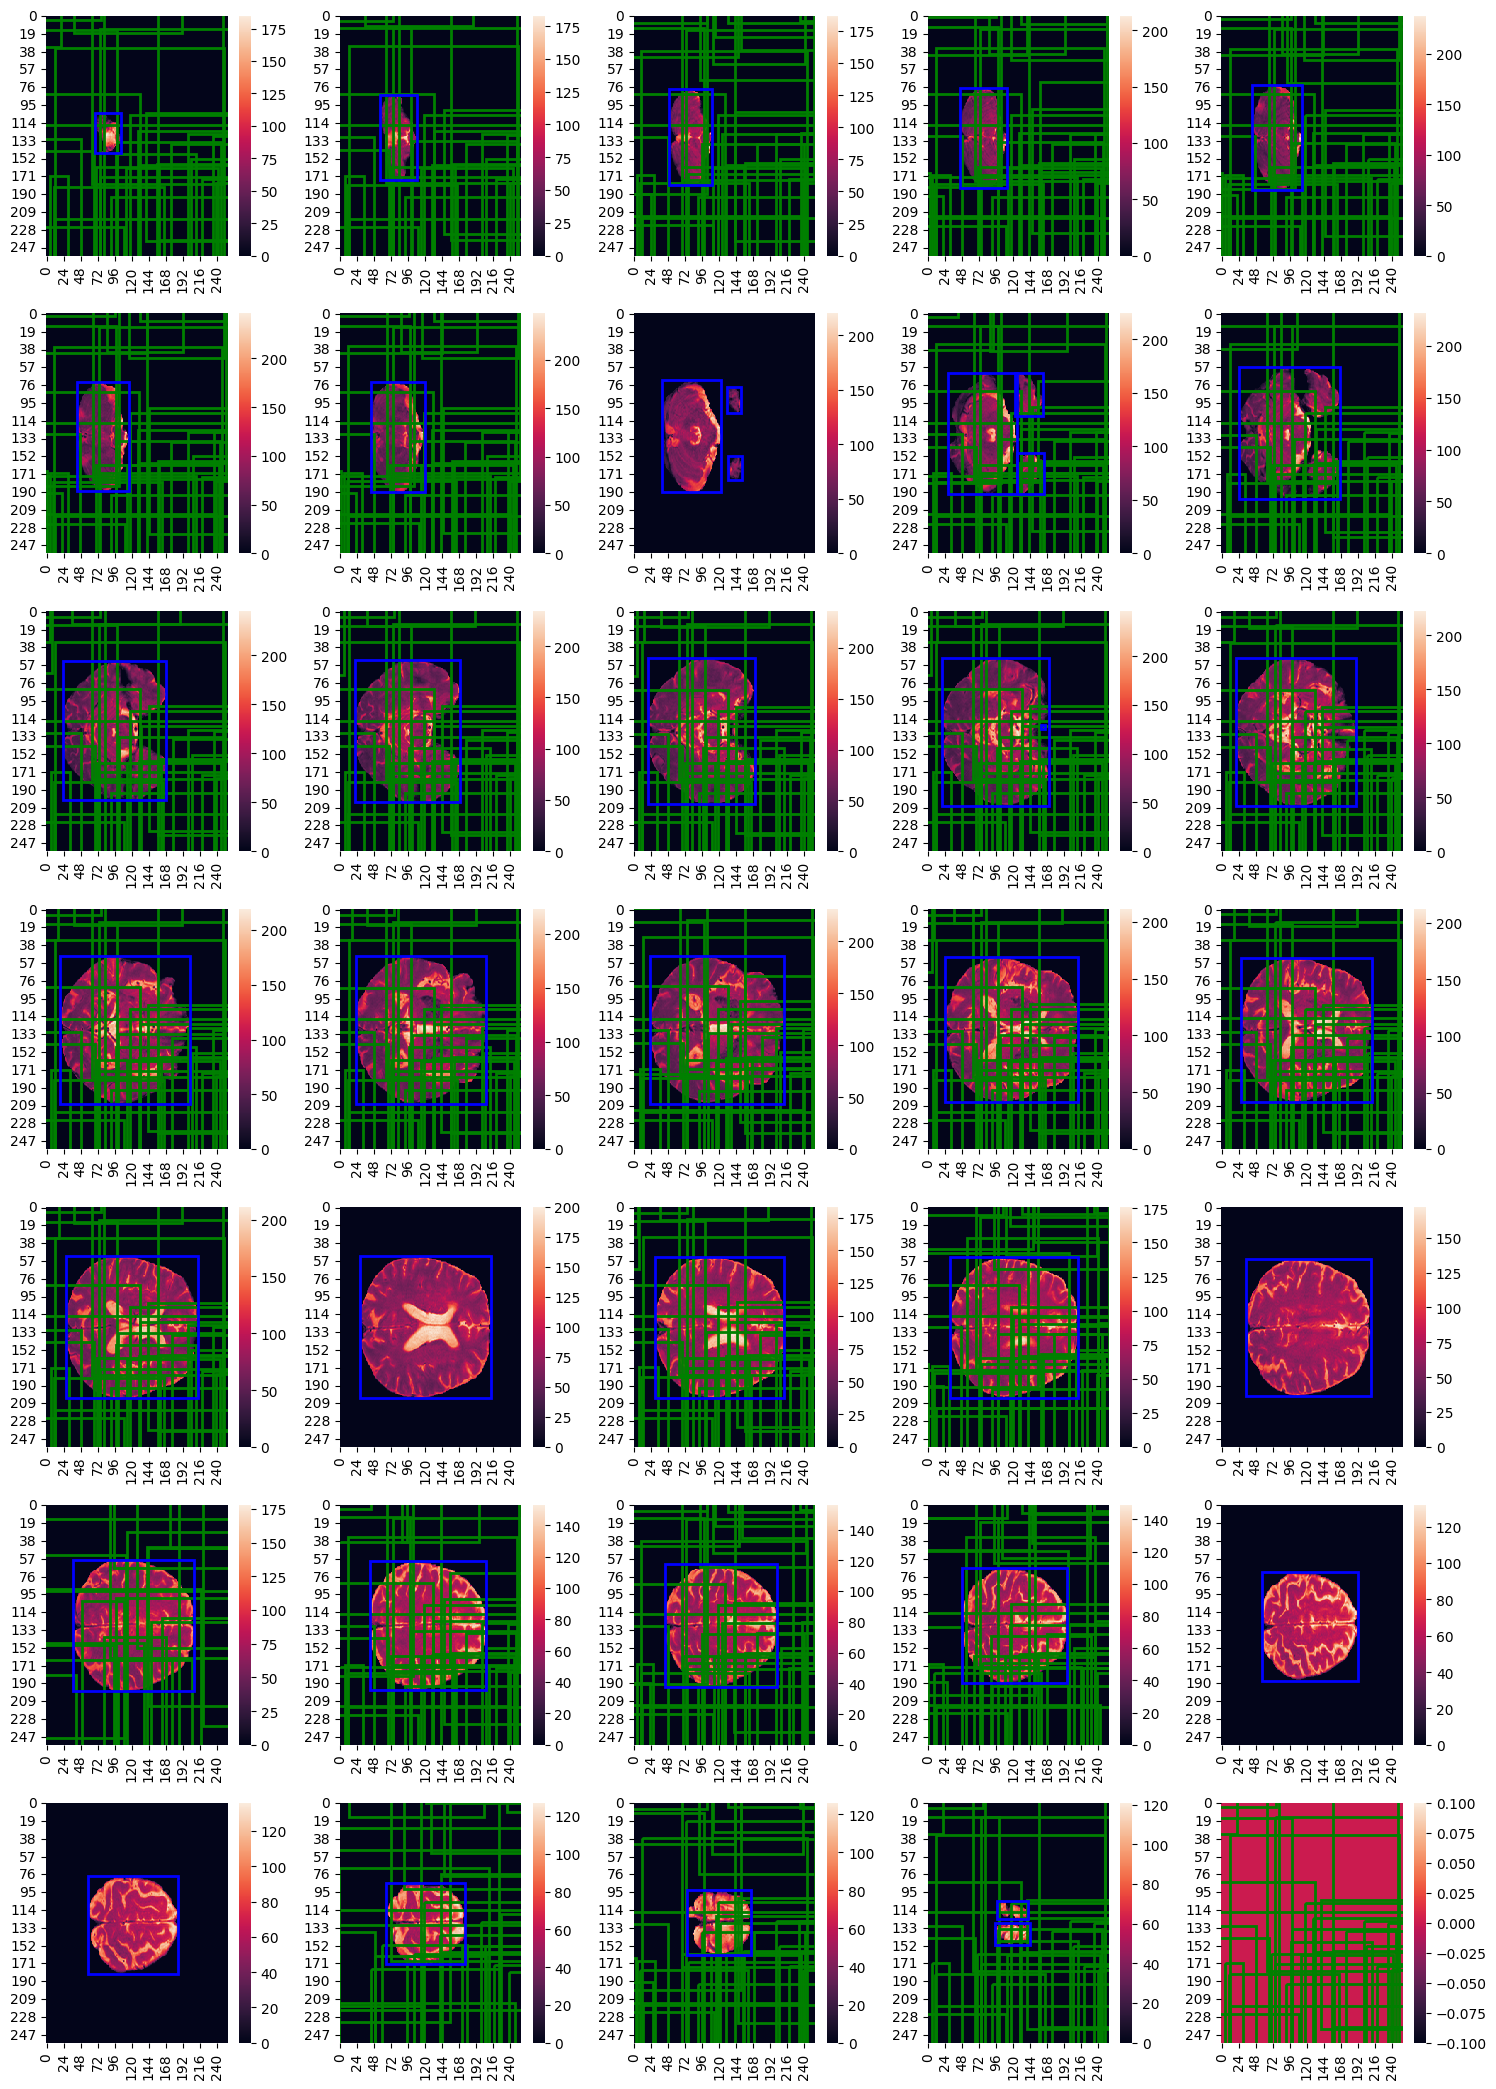

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Assuming you have defined `targets` and `slices` elsewhere in your code
slices, targets, id, count = test_dataset_all_axial[0]
# Calculate the number of subplots needed based on the length of your data
num_slices = len(slices)
num_cols = 5
# Round up to the nearest integer
num_rows = (num_slices + num_cols - 1) // num_cols

# Create the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
print(targets[8]['boxes'])
# Iterate over slices and targets
for idx, (slice_base, target) in enumerate(zip(slices, targets)):
    row = idx // num_cols
    col = idx % num_cols
    ax = axes[row, col]

    # Generate heatmap
    heatmap_data = torch.mean(slice_base.float(), dim=0)
    heatmap_data_np = heatmap_data.numpy()
    sns.heatmap(heatmap_data_np, ax=ax)

    # Generate bounding box
    print(idx)
    boxes = predicted_boxes[idx]
    for box in boxes:
        box = torch.from_numpy(box)
        x_min, y_min, x_max, y_max = box
        ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                   linewidth=2, edgecolor='g', facecolor='none'))

    boxes = target['boxes']
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                   linewidth=2, edgecolor='b', facecolor='none'))


plt.tight_layout()
plt.show()

## Get all the predicted bounding boxes

Returns a dataframe of all the prediction with the image_id and the slice_num


In [46]:
def get_predicted_marking(dataset, prediction_list):
    predicted_cmbs = {
        'image_id': [],
        'slice_num': [],
        'x': [],
        'y': [],
        'w': [],
        'h': []
    }

    for i in range(len(dataset)):
        slices, _, id, count = dataset[i]
        predictions = prediction_list[i]['predictions']
        for j in range(len(slices)):
            for k in range(len(predictions[j]['boxes'])):
                box = predictions[j]['boxes'][k]
                x_min, y_min, w, h = box
                predicted_cmbs['image_id'].append(id)
                predicted_cmbs['slice_num'].append(j)
                predicted_cmbs['x'].append(x_min)
                predicted_cmbs['y'].append(y_min)
                predicted_cmbs['w'].append(w)
                predicted_cmbs['h'].append(h)

    # Convert to DataFrame once at the end
    predicted_cmbs_df = pd.DataFrame(predicted_cmbs)
    return predicted_cmbs_df

## Variables for all the ground truth and predicted CMBs


In [48]:
all_marking = get_all_marking(test_dataset_all_axial)
predicted_marking = get_predicted_marking(
    test_dataset_all_axial, prediction_list)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1

## Dataframes of cases with and without CMB


In [49]:
df_with_cmb = df_dataset[df_dataset['Has CMB'] == 1]
df_without_cmb = df_dataset[df_dataset['Has CMB'] == 0]

In [53]:
test_dataset_with_cmb = VALDODataset(
    img_paths=df_with_cmb['MRI Scans'].tolist(),
    ann_paths=df_with_cmb['Segmented Masks'].tolist(),
    transform=transform
)

test_dataset_without_cmb = VALDODataset(
    img_paths=df_without_cmb['MRI Scans'].tolist(),
    ann_paths=df_without_cmb['Segmented Masks'].tolist(),
    transform=transform
)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [54]:
result_with_cmb = count_FPTP(all_marking, predicted_marking)
result_without_cmb = count_FPTP(all_marking, predicted_marking)

C:\Users\JOSHUA KYLE\AppData\Local\Temp\ipykernel_20940\1603764280.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tp = pd.concat([tp, temp], ignore_index=True)
C:\Users\JOSHUA KYLE\AppData\Local\Temp\ipykernel_20940\1603764280.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tp = pd.concat([tp, temp], ignore_index=True)


## Precision and Recall of the model


### Performance Metric


In [60]:
def performance_metric(results, dataset_len, cmb_absent=False):
    precision = 0.0
    recall = 0.0

    if not cmb_absent:
        try:
            precision = results[3]/(results[3] + results[1])
        except ZeroDivisionError:
            precision = 0.0

        try:
            recall = results[3]/(results[3] + results[5])
        except ZeroDivisionError:
            recall = 0.0

    try:
        fp_ave = results[1]/dataset_len
    except ZeroDivisionError:
        fp_ave = 0.0

    return precision, recall, fp_ave

#### Results for CMBs Present


In [61]:
with_cmb_result = performance_metric(
    result_with_cmb, len(test_dataset_with_cmb))

print('Model\'s precision:', with_cmb_result[0])
print('Model\'s recall:', with_cmb_result[1])
print('Model\'s fp ave:', with_cmb_result[2])

Model's precision: 0.03660714285714286
Model's recall: 0.31297709923664124
Model's fp ave: 21.58


#### Results for CMBs Absent


In [62]:
without_cmb_result = performance_metric(
    result_without_cmb, len(test_dataset_without_cmb), True)

print('Model\'s fp ave:', without_cmb_result[2])

Model's fp ave: 49.04545454545455
